In [1]:
import json, random, math, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import librosa
from torch.utils.data import Dataset, DataLoader
import sys
from pathlib import Path as _Path

# Make sure project root (the folder that contains ./scripts/models.py) is on sys.path
_proj = _Path.cwd().resolve()
while _proj != _proj.parent and not (_proj / "scripts" / "models.py").exists():
    _proj = _proj.parent
if (_proj / "scripts" / "models.py").exists() and str(_proj) not in sys.path:
    sys.path.insert(0, str(_proj))

from scripts.models import VAE, vae_loss as vae_loss_fn, linear_beta_schedule


In [2]:
# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Audio params
SR = 16000
N_MELS = 80
N_FFT = 1024
HOP = 256
T = 128  # frames fixos

# Treino
BATCH_SIZE = 128   # ajuste: 16 se ficar pesado
EPOCHS = 15        # só pra começar
LR = 1e-3

# Beta-VAE / anti-collapse
BETA_MAX = 2.0
WARMUP_STEPS = 500   # com DataLoader faz sentido ser maior
FREE_BITS = 0.5      # 0.5 ou 1.0 (0.5 costuma ser mais suave)

# Paths (ajuste se necessário)
DATA_ROOT = Path("../data/nsynth-valid.jsonwav/nsynth-valid")
AUDIO_DIR = DATA_ROOT / "audio"
JSON_PATH = DATA_ROOT / "examples.json"

print("AUDIO_DIR exists:", AUDIO_DIR.exists())
print("JSON_PATH exists:", JSON_PATH.exists())


device: cuda
AUDIO_DIR exists: True
JSON_PATH exists: True


In [3]:
with open(JSON_PATH, "r") as f:
    examples = json.load(f)

keys = list(examples.keys())
random.shuffle(keys)

val_ratio = 0.1
n_val = int(len(keys) * val_ratio)

val_keys = keys[:n_val]
train_keys = keys[n_val:]

print("Total:", len(keys))
print("Train:", len(train_keys))
print("Val  :", len(val_keys))


Total: 12678
Train: 11411
Val  : 1267


In [4]:
from tqdm import tqdm
import os

CACHE_DIR = Path("../data/nsynth_mel_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

def cache_one(key: str):
    out_path = CACHE_DIR / f"{key}.pt"
    if out_path.exists():
        return

    wav_path = AUDIO_DIR / f"{key}.wav"
    audio, sr = librosa.load(wav_path, sr=SR, mono=True)

    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel, ref=np.max)
    log_mel = np.clip(log_mel, -80.0, 0.0)

    x = (log_mel + 80.0) / 80.0   # [0, 1]
    x = 2.0 * x - 1.0             # [-1, 1]

    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # (1,80,time)

    # pad/crop to T
    time_frames = x.shape[-1]
    if time_frames >= T:
        x = x[:, :, :T]
    else:
        x = F.pad(x, (0, T - time_frames))

    torch.save(x, out_path)

# escolha um subset primeiro se quiser testar rápido
# keys_to_cache = train_keys[:5000] + val_keys[:1000]
keys_to_cache = train_keys + val_keys

for k in tqdm(keys_to_cache, desc="Caching log-mels"):
    cache_one(k)

print("Cache ready at:", CACHE_DIR)


Caching log-mels: 100%|██████████| 12678/12678 [00:00<00:00, 191294.19it/s]

Cache ready at: ../data/nsynth_mel_cache


In [5]:
def wav_to_logmel_norm(audio: np.ndarray, sr: int) -> np.ndarray:
    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel, ref=np.max)
    log_mel = np.clip(log_mel, -80.0, 0.0)

    # [-80,0] -> [0,1] -> [-1,1]
    x = (log_mel + 80.0) / 80.0
    x = 2.0 * x - 1.0
    return x  # (80, time)


In [6]:
### Original Data Loader (on-the-fly processing)

class NSynthLogMelDataset(Dataset):
    def __init__(self, keys, examples, audio_dir: Path):
        self.keys = keys
        self.examples = examples
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]
        wav_path = self.audio_dir / f"{k}.wav"

        audio, sr = librosa.load(wav_path, sr=SR, mono=True)
        x = wav_to_logmel_norm(audio, sr)  # (80, time)

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # (1, 80, time)

        # pad/crop to (1,80,T)
        time_frames = x.shape[-1]
        if time_frames >= T:
            x = x[:, :, :T]
        else:
            x = F.pad(x, (0, T - time_frames))

        pitch = self.examples[k]["pitch"]
        family = self.examples[k]["instrument_family"]

        return x, pitch, family, k
    
### Cached version Data Loader

class CachedNSynthDataset(Dataset):
    def __init__(self, keys, examples, cache_dir: Path):
        self.keys = keys
        self.examples = examples
        self.cache_dir = cache_dir

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]
        x = torch.load(self.cache_dir / f"{k}.pt")  # (1,80,T)

        pitch = self.examples[k]["pitch"]
        family = self.examples[k]["instrument_family"]
        return x, pitch, family, k


In [7]:
train_ds = CachedNSynthDataset(train_keys, examples, CACHE_DIR)
val_ds   = CachedNSynthDataset(val_keys, examples, CACHE_DIR)

pin = (device.type == "cuda")

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=8, pin_memory=pin, persistent_workers=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=8, pin_memory=pin, persistent_workers=True, prefetch_factor=2
)

# sanity check
x, pitch, family, k = next(iter(train_loader))
print("batch x:", tuple(x.shape), "pitch:", pitch[:5].tolist(), "family:", family[:5].tolist())


/tmp/ipykernel_17127/3765502276.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(self.cache_dir / f"{k}.pt")  # (1,80,T)
/tmp/ipykernel_17127/3765502276.p

batch x: (128, 1, 80, 128) pitch: [61, 59, 40, 89, 61] family: [3, 0, 1, 6, 0]


In [8]:
# Model moved to scripts/models.py
# Using: VAE (baseline), plus loss + beta schedule helpers


In [9]:
# Loss + beta schedule wrappers (imported from scripts/models.py)

vae_loss = vae_loss_fn  # keep old name used in the notebook

def beta_schedule(global_step: int) -> float:
    # linear warmup 0 -> BETA_MAX
    return linear_beta_schedule(global_step, warmup_steps=WARMUP_STEPS, beta_max=BETA_MAX)


In [10]:
vae = VAE(latent_dim=32).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=LR)

global_step = 0

for epoch in range(1, EPOCHS + 1):
    vae.train()
    t0 = time.time()

    tr_total = tr_recon = tr_kl_raw = tr_kl_fb = 0.0
    n_batches = 0

    for x, pitch, family, k in train_loader:
        x = x.to(device, non_blocking=True)
        beta = beta_schedule(global_step)

        x_hat, mu, logvar, z = vae(x)
        total, recon, kl_mean, kl_fb = vae_loss(x_hat, x, mu, logvar, beta, FREE_BITS)

        opt.zero_grad()
        total.backward()
        opt.step()

        tr_total += float(total)
        tr_recon += float(recon)
        tr_kl_raw += float(kl_mean)
        tr_kl_fb += float(kl_fb)
        n_batches += 1
        global_step += 1

        # log ocasional
        if global_step % 200 == 0:
            print(f"[step {global_step}] beta={beta:.3f} total={float(total):.3f} recon={float(recon):.3f} kl_raw={float(kl_mean):.3f} kl_fb={float(kl_fb):.3f}")

    # médias treino
    tr_total /= n_batches
    tr_recon /= n_batches
    tr_kl_raw /= n_batches
    tr_kl_fb /= n_batches

    # validação
    vae.eval()
    va_total = va_recon = va_kl_raw = va_kl_fb = 0.0
    va_batches = 0

    with torch.no_grad():
        for x, pitch, family, k in val_loader:
            x = x.to(device, non_blocking=True)
            beta = beta_schedule(global_step)  # ok usar o step atual

            x_hat, mu, logvar, z = vae(x)
            total, recon, kl_mean, kl_fb = vae_loss(x_hat, x, mu, logvar, beta, FREE_BITS)

            va_total += float(total)
            va_recon += float(recon)
            va_kl_raw += float(kl_mean)
            va_kl_fb += float(kl_fb)
            va_batches += 1

    va_total /= va_batches
    va_recon /= va_batches
    va_kl_raw /= va_batches
    va_kl_fb /= va_batches

    dt = time.time() - t0
    print(f"\nEpoch {epoch}/{EPOCHS} ({dt:.1f}s)")
    print(f"  Train: total={tr_total:.3f} recon={tr_recon:.3f} kl_raw={tr_kl_raw:.3f} kl_fb={tr_kl_fb:.3f}")
    print(f"  Val  : total={va_total:.3f} recon={va_recon:.3f} kl_raw={va_kl_raw:.3f} kl_fb={va_kl_fb:.3f}\n")


/tmp/ipykernel_17127/3765502276.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(self.cache_dir / f"{k}.pt")  # (1,80,T)
/tmp/ipykernel_17127/3765502276.p


Epoch 1/15 (4.0s)
  Train: total=0.393 recon=0.302 kl_raw=0.358 kl_fb=0.538
  Val  : total=0.423 recon=0.233 kl_raw=0.459 kl_fb=0.527


Epoch 2/15 (0.8s)
  Train: total=0.505 recon=0.234 kl_raw=0.389 kl_fb=0.503
  Val  : total=0.588 recon=0.225 kl_raw=0.439 kl_fb=0.505

[step 200] beta=0.796 total=0.625 recon=0.225 kl_raw=0.309 kl_fb=0.502

Epoch 3/15 (0.7s)
  Train: total=0.691 recon=0.239 kl_raw=0.319 kl_fb=0.503
  Val  : total=0.771 recon=0.229 kl_raw=0.379 kl_fb=0.501


Epoch 4/15 (0.7s)
  Train: total=0.853 recon=0.223 kl_raw=0.407 kl_fb=0.501
  Val  : total=0.932 recon=0.212 kl_raw=0.425 kl_fb=0.500

[step 400] beta=1.596 total=1.014 recon=0.216 kl_raw=0.422 kl_fb=0.500

Epoch 5/15 (0.8s)
  Train: total=1.020 recon=0.210 kl_raw=0.433 kl_fb=0.501
  Val  : total=1.117 recon=0.217 kl_raw=0.403 kl_fb=0.500


Epoch 6/15 (0.8s)
  Train: total=1.178 recon=0.206 kl_raw=0.440 kl_fb=0.501
  Val  : total=1.204 recon=0.204 kl_raw=0.421 kl_fb=0.500

[step 600] beta=2.000 total=1.195 recon=0.

# Measuring Timbre Space

In [11]:
vae.eval()

N_SAMPLES = 2000
mus = []
pitches = []
families = []
keys = []

with torch.no_grad():
    for x, pitch, family, k in tqdm(val_loader, desc="Extracting mu"):
        x = x.to(device, non_blocking=True)

        # Forward do VAE: ajuste conforme seu forward retorna
        # Esperado: x_hat, mu, logvar, z  (ou algo parecido)
        out = vae(x)

        # --- Ajuste aqui conforme seu modelo ---
        # Caso seu forward retorne tupla:
        # x_hat, mu, logvar, z = out
        # Caso retorne dict: mu = out["mu"]
        if isinstance(out, (tuple, list)):
            # tente os formatos mais comuns
            if len(out) == 4:
                _, mu, _, _ = out
            elif len(out) == 3:
                _, mu, _ = out
            else:
                raise RuntimeError(f"Unexpected VAE output length: {len(out)}")
        elif isinstance(out, dict):
            mu = out["mu"]
        else:
            raise RuntimeError(f"Unexpected VAE output type: {type(out)}")
        # --- fim do ajuste ---

        mus.append(mu.detach().cpu().numpy())
        pitches.append(np.array(pitch))
        families.append(np.array(family))
        keys.extend(list(k))

        if sum(m.shape[0] for m in mus) >= N_SAMPLES:
            break

mu_np = np.concatenate(mus, axis=0)[:N_SAMPLES]
pitch_np = np.concatenate(pitches, axis=0)[:N_SAMPLES]
family_np = np.concatenate(families, axis=0)[:N_SAMPLES]
keys = keys[:N_SAMPLES]

print("mu:", mu_np.shape, "pitch:", pitch_np.shape, "family:", family_np.shape)
print("mu mean/std:", mu_np.mean(), mu_np.std())
print("pitch min/max:", pitch_np.min(), pitch_np.max())
print("unique families:", np.unique(family_np))


Extracting mu:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_17127/3765628835.py:36: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pitches.append(np.array(pitch))
/tmp/ipykernel_17127/3765628835.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  families.append(np.array(family))
Extracting mu: 100%|██████████| 10/10 [00:00<00:00, 101.41it/s]

mu: (1267, 32) pitch: (1267,) family: (1267,)
mu mean/std: -0.006796803 0.115491904
pitch min/max: 9 116
unique families: [ 0  1  2  3  4  5  6  7  8 10]


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
mu_pca = pca.fit_transform(mu_np)

print("PCA explained variance ratio:", pca.explained_variance_ratio_, "sum:", pca.explained_variance_ratio_.sum())


PCA explained variance ratio: [0.8619322 0.1267377] sum: 0.98866993


In [13]:

import umap

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)
mu_umap = umap_model.fit_transform(mu_np)

print("UMAP:", mu_umap.shape)


/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP: (1267, 2)


In [14]:

import pandas as pd
import plotly.express as px


In [15]:
df = pd.DataFrame({
    "x_pca": mu_pca[:, 0],
    "y_pca": mu_pca[:, 1],
    "x_umap": mu_umap[:, 0],
    "y_umap": mu_umap[:, 1],
    "pitch": pitch_np.astype(int),
    "family": family_np.astype(int),
    "key": keys,
})

df.head()


,x_pca,y_pca,x_umap,y_umap,pitch,family,key
0,0.833125,0.024275,11.270432,6.035417,49,4,keyboard_electronic_001-049-127
1,1.091397,-0.068974,13.716315,2.656745,42,0,bass_synthetic_009-042-025
2,-0.540847,-0.020761,-2.665763,3.379412,64,3,guitar_acoustic_014-064-075
3,0.075552,-0.036221,5.979167,6.782880,60,1,brass_acoustic_015-060-050
4,-0.396369,-0.026089,-0.413781,4.348168,51,4,keyboard_synthetic_000-051-050


In [16]:
import nbformat
fig = px.scatter(
    df,
    x="x_pca",
    y="y_pca",
    color="pitch",
    hover_data=["key", "family", "pitch"],
    title="PCA(mu) — colored by pitch",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [24]:
df["family_str"] = df["family"].astype(str)

fig = px.scatter(
    df,
    x="x_pca",
    y="y_pca",
    color="family_str",
    hover_data=["key", "family", "pitch"],
    title="PCA(mu) — colored by instrument_family",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [25]:
fig = px.scatter(
    df,
    x="x_umap",
    y="y_umap",
    color="pitch",
    hover_data=["key", "family", "pitch"],
    title="UMAP(mu) — colored by pitch",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [26]:
fig = px.scatter(
    df,
    x="x_umap",
    y="y_umap",
    color="family_str",
    hover_data=["key", "family", "pitch"],
    title="UMAP(mu) — colored by instrument_family",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [27]:
fig = px.scatter(
    df,
    x="x_umap",
    y="y_umap",
    color="pitch",
    facet_col="family_str",
    facet_col_wrap=4,
    hover_data=["key", "family", "pitch"],
    title="UMAP(mu) faceted by instrument_family (color=pitch)",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=4))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()


# Tests

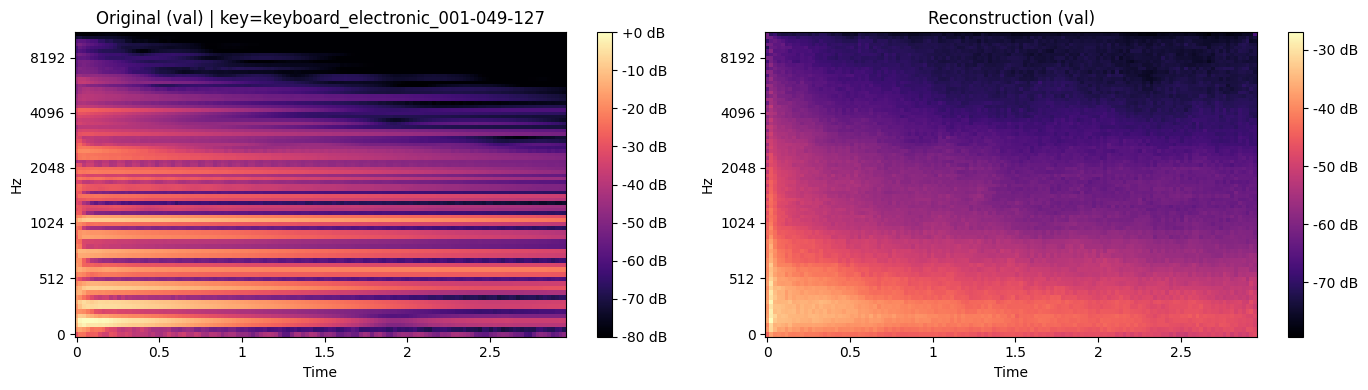

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def denormalize_db(x_norm):
    return ((x_norm + 1.0) / 2.0) * 80.0 - 80.0
# family_str
vae.eval()
x, pitch, family, k = next(iter(val_loader))
x = x.to(device, non_blocking=True)

with torch.no_grad():
    x_hat, mu, logvar, z = vae(x)

i = 0
orig = denormalize_db(x[i,0].cpu().numpy())
rec  = denormalize_db(x_hat[i,0].cpu().numpy())

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
img1 = librosa.display.specshow(orig, ax=axs[0], x_axis="time", y_axis="mel")
axs[0].set_title(f"Original (val) | key={k[i]}")
fig.colorbar(img1, ax=axs[0], format="%+2.0f dB")

img2 = librosa.display.specshow(rec, ax=axs[1], x_axis="time", y_axis="mel")
axs[1].set_title("Reconstruction (val)")
fig.colorbar(img2, ax=axs[1], format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [12]:
ckpt = {
    "model_state": vae.state_dict(),
    "config": {
        "SR": SR, "N_MELS": N_MELS, "N_FFT": N_FFT, "HOP": HOP, "T": T,
        "BATCH_SIZE": BATCH_SIZE, "LR": LR,
        "BETA_MAX": BETA_MAX, "WARMUP_STEPS": WARMUP_STEPS, "FREE_BITS": FREE_BITS,
        "latent_dim": 32,
        "seed": SEED,
    },
    "global_step": global_step,
}

out_path = Path("vae_nsynth_ckpt.pt")
torch.save(ckpt, out_path)
print("Saved:", out_path)


Saved: vae_nsynth_ckpt.pt
